In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import mnist
import numpy as np
import os



# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


input_img = Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Flatten()(x)
# Add a bottleneck layer with 2 neurons
encoded = layers.Dense(2, activation='relu')(x)

# Reshape back to the shape before flattening
x = layers.Dense(4 * 4 * 8, activation='relu')(encoded)
x = layers.Reshape((4, 4, 8))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


# Check if model weights are available and load them

weights_path = 'mnist_autoencoder.h5'
if os.path.exists(weights_path):
    autoencoder.load_weights(weights_path)


# Train the autoencoder
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))



2025-02-14 23:01:41.358276: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
  3/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.2141

2025-02-14 23:01:42.900566: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - loss: 0.1997 - val_loss: 0.1963
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - loss: 0.1966 - val_loss: 0.1961
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 0.1959 - val_loss: 0.1952
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - loss: 0.1952 - val_loss: 0.1945
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - loss: 0.1938 - val_loss: 0.1935
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - loss: 0.1943 - val_loss: 0.1936
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - loss: 0.1934 - val_loss: 0.1933
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - loss: 0.1934 - val_loss: 0.1937
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 0.1927 - val_loss: 0.1935
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - loss: 0.1919 - val_loss: 0.1918


In [4]:
# Save the model
autoencoder.save('mnist_autoencoder.h5')

# Create the encoder model
encoder = models.Model(inputs=input_img, outputs=encoded)
encoder.save('mnist_encoder.h5')

# Create the decoder model

encoded_input = Input(shape=(2,))
x = encoded_input
for layer in autoencoder.layers[-9:]:
    x = layer(x)
decoder = models.Model(inputs=encoded_input, outputs=x)
decoder.save('mnist_decoder.h5')

In [5]:
from tensorflow.keras.models import load_model


# Load the autoencoder model
autoencoder = load_model('mnist_autoencoder.h5')
encoder = load_model('mnist_encoder.h5')
decoder = load_model('mnist_decoder.h5')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


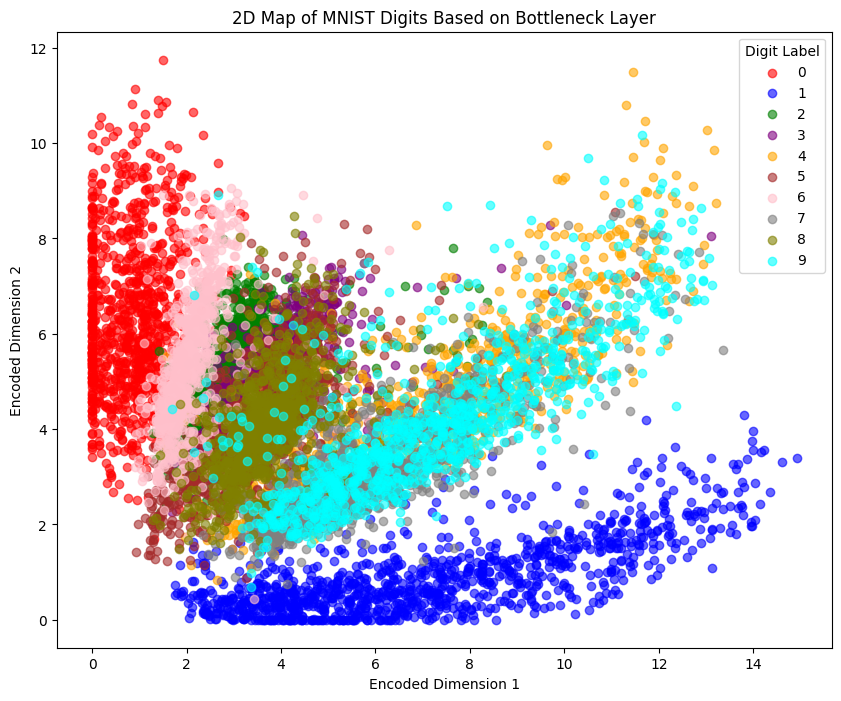

In [6]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Load the MNIST dataset with labels
(_, y_train), (_, y_test) = mnist.load_data()

# Encode the test data
encoded_imgs = encoder.predict(x_test)

# Define colors for each digit class
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Plot the encoded values in a 2D scatter plot
plt.figure(figsize=(10, 8))
for digit in range(10):
    indices = np.where(y_test == digit)
    plt.scatter(encoded_imgs[indices, 0], encoded_imgs[indices, 1], c=colors[digit], label=str(digit), alpha=0.6)

plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.title('2D Map of MNIST Digits Based on Bottleneck Layer')
plt.legend(title='Digit Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


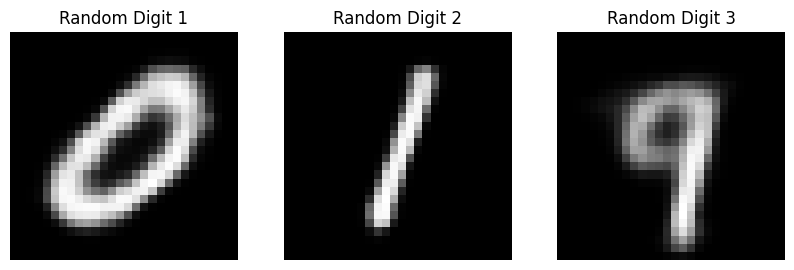

In [7]:
import matplotlib.pyplot as plt

# Generate 3 random encoded vectors
random_encoded_vectors = np.array([[0.1, 4], [6, 0], [8, 4]])

# Decode the random vectors
decoded_imgs = decoder.predict(random_encoded_vectors)

# Plot the decoded images
plt.figure(figsize=(10, 4))
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title(f'Random Digit {i+1}')
    plt.axis('off')
plt.show()

In [ ]:
import numpy as np
from ipywidgets import FloatSlider, interactive, HBox, VBox
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

# Load the MNIST dataset with labels
(_, y_train), (_, y_test) = mnist.load_data()

# Encode the test data
encoded_imgs = encoder.predict(x_test)

# Define colors for each digit class
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']

# Function to update the plot
def update_plot(x, y):
    plt.figure(figsize=(12, 6))
    
    # Plot the encoded values in a 2D scatter plot
    plt.subplot(1, 2, 1)
    for digit in range(10):
        indices = np.where(y_test == digit)
        plt.scatter(encoded_imgs[indices, 0], encoded_imgs[indices, 1], c=colors[digit], label=str(digit), alpha=0.6)
    plt.scatter(x, y, c='black', marker='x', s=100)  # Cursor position
    plt.xlabel('Encoded Dimension 1')
    plt.ylabel('Encoded Dimension 2')
    plt.title('2D Map of MNIST Digits Based on Bottleneck Layer')
    plt.legend(title='Digit Label')
    
    # Decode the cursor position
    decoded_img = decoder.predict(np.array([[x, y]]))
    
    # Plot the decoded image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_img[0].reshape(28, 28), cmap='gray')
    plt.title('Decoded Image')
    plt.axis('off')
    
    plt.show()

# Create sliders for x and y coordinates
x_slider = FloatSlider(min=-10, max=10, step=0.1, description='x')
y_slider = FloatSlider(min=-10, max=10, step=0.1, description='y')

# Create interactive plot
interactive_plot = interactive(update_plot, x=x_slider, y=y_slider)
display(HBox([interactive_plot.children[0], interactive_plot.children[1]]), interactive_plot.children[2])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Output()